In [1]:
import re
import math
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition, preprocessing
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

In [2]:
def textFileToWordCounts(filename,minCount):

    # read in document and create a vector of term counts
    fileptr = open(filename)

    # dictionary of words to counts
    wordmap = {}

    for line in fileptr:
        for token in line.split(" "):
            # convert to lowercase
            lowertoken = token.lower()
            # strip all non-character with regex
            striptoken = re.sub(r"[^a-z]","",lowertoken)
            if len(striptoken)>0:
                if striptoken not in wordmap.keys():
                    wordmap[striptoken]=0
                wordmap[striptoken]=wordmap[striptoken]+1
    fileptr.close()
    
    # prune out words with fewer than minCount occurences
    for token in list(wordmap.keys()):
        if wordmap[token] < minCount:
            del wordmap[token]
    #return dictionary of counts
    return wordmap


In [3]:
tmpWordMap = textFileToWordCounts('data/purdue.txt',3)
print(len(tmpWordMap))
print(tmpWordMap)

55
{'purdue': 28, 'university': 25, 'is': 10, 'a': 13, 'research': 17, 'in': 35, 'lafayette': 3, 'and': 37, 'the': 54, 'campus': 3, 'of': 30, 'was': 6, 'to': 12, 'science': 3, 'technology': 4, 'agriculture': 5, 'on': 4, 'with': 4, 'more': 5, 'than': 5, 'for': 3, 'medicine': 3, 'has': 6, 'student': 3, 'member': 3, 'big': 4, 'ten': 4, 'as': 4, 'association': 3, 'american': 3, 'universities': 4, 'among': 3, 'million': 5, 'from': 6, 'institutions': 3, 'by': 8, 'also': 4, 'areas': 3, 'are': 4, 'engineering': 3, 'manufacturing': 3, 'global': 4, 'foundation': 4, 'discovery': 3, 'park': 6, 'an': 4, 'including': 3, 'libraries': 4, 'books': 3, 'at': 4, 'press': 5, 'other': 3, 'print': 3, 'academic': 3, 'btaa': 4}


In [4]:
import os

# calculate term vector for set of files
directory = 'data'
minThresh=3
fileMap = {}
uniqueWords = set()
for filename in os.listdir(directory):
    tmpWordMap = textFileToWordCounts(directory + '/' + filename, minThresh)
    #print(len(tmpWordMap))
    fileMap[filename] = tmpWordMap
    # add words to overall list of words
    for tmpWord in tmpWordMap.keys():
        uniqueWords.add(tmpWord)

# create a document term matrix for the set of files
fileList = list(fileMap.keys())
numFiles = len(fileList)
numWords = len(uniqueWords)
uniqueWordList = list(uniqueWords)
uniqueWordList.sort()
print('Num words ' + str(numWords) + ', num files '+ str(numFiles))

# initialize matrix to zeros
termMatrix = np.zeros((numFiles,numWords))
# loop over each wordmap
for file in fileList:
    rowIdx = fileList.index(file)
    tmpWordMap = fileMap[file]
    for token in tmpWordMap.keys():
        # find location of word
        colIdx = uniqueWordList.index(token)
        # update count for appropriate cell of matrix
        termMatrix[rowIdx,colIdx]=tmpWordMap[token]
print(termMatrix[:6,:12])
print(fileList)

Num words 169, num files 6
[[18.  3.  0.  0.  0.  0.  9.  0.  0.  0.  0. 45.]
 [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 17.]
 [10.  3.  0.  3.  0.  0.  5.  0.  0.  4.  0. 25.]
 [14.  0.  3.  0.  0.  3.  3.  3.  3.  0.  4. 58.]
 [11.  5.  0.  0.  3.  0.  0.  0.  0.  0.  0. 28.]
 [13.  3.  0.  0.  5.  0.  4.  0.  3.  3.  4. 37.]]
['uiuc.txt', 'kentucky.txt', 'osu.txt', 'cornell.txt', 'msu.txt', 'purdue.txt']


'a'

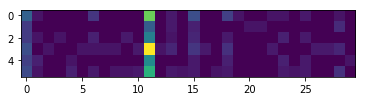

In [5]:
# visualize the data
#plt.imshow(termMatrix)
plt.imshow(termMatrix[:,:30])
uniqueWordList[0]

In [6]:
# reduce dimensionality with PCA
def applyPCA(data,numCmps):
    # mean center data
    X_scaled = preprocessing.scale(data, with_std=False) 
    # initialize PCA model
    pca = decomposition.PCA(n_components=numCmps)
    # fit PCA model with scaled data 
    X_trans = pca.fit_transform(X_scaled)
    # return transformed data and explained variance
    return [X_trans, pca.explained_variance_ratio_]

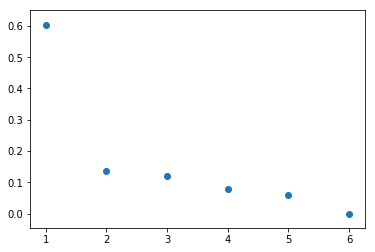

In [7]:
[transData, exvar] = applyPCA(termMatrix,numFiles)
# determine best number of dimensions
cmpIdx=range(1,numFiles+1)
plt.scatter(cmpIdx,exvar)

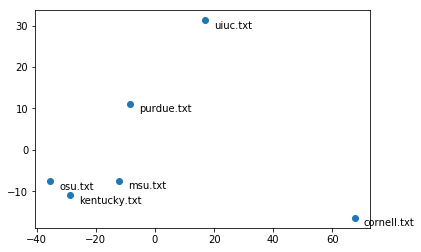

In [8]:
# plot transformed data, 1st two dimensions
plt.scatter(transData[:,0],transData[:,1])
# label points
for file in fileList:
    idx = fileList.index(file)
    plt.text(transData[idx,0]+3,transData[idx,1]-2,file) 

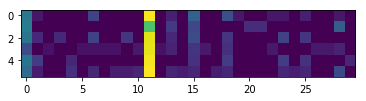

In [9]:
# normalize for document length
normMatrix = termMatrix.copy()
for i in range(termMatrix.shape[0]):
    docLen = sum(termMatrix[i,:])
    normMatrix[i,:] = termMatrix[i,:]/docLen
plt.imshow(normMatrix[:,:30])

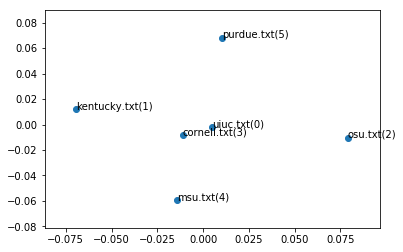

In [10]:
# apply PCA to normalized data
[transNormData, exvar] = applyPCA(normMatrix,numFiles)

plt.scatter(transNormData[:,0],transNormData[:,1])
# label points
for file in fileList:
    idx = fileList.index(file)
    plt.text(transNormData[idx,0],transNormData[idx,1],file+'('+str(idx)+')') 

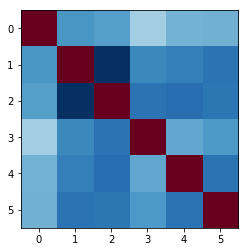

In [11]:
# calculate distances between documents
dists = euclidean_distances(transNormData)
plt.imshow(dists,cmap='RdBu')

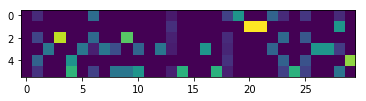

In [12]:
# multiply term frequency by inverse document frequency 
# IDF(t) = log(Num of docs / Num of docs with term t in it)
tfidfMatrix = normMatrix.copy()
for j in range(normMatrix.shape[1]):
    docswterm = 0
    for i in range(numFiles):
        if normMatrix[i,j]>0:
            docswterm = docswterm+1
    termidf = 0
    if docswterm > 0:
        #print(str(j) + ':' + str(docswterm))
        termidf = math.log(numFiles/docswterm)
    #print(str(j) + ':' + str(termidf))
    tfidfMatrix[:,j] = normMatrix[:,j]*termidf
plt.imshow(tfidfMatrix[:,:30])

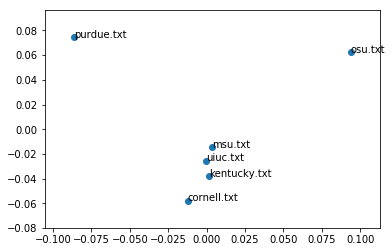

In [13]:
# apply PCA to normalized data
[transTFIDFData, exvar] = applyPCA(tfidfMatrix,numFiles)

plt.scatter(transTFIDFData[:,0],transTFIDFData[:,1])
# label points
for file in fileList:
    idx = fileList.index(file)
    plt.text(transTFIDFData[idx,0],transTFIDFData[idx,1],file) 

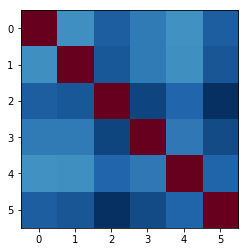

In [14]:
# calculate distances between documents
dists = euclidean_distances(transTFIDFData)
plt.imshow(dists,cmap='RdBu')

In [15]:
# find words with largest variance
vars = []
for j in range(tfidfMatrix.shape[1]):
    tmpvar = np.var(tfidfMatrix[:,j])
    vars.append(tmpvar)
print(max(vars))
thresh = np.percentile(vars,90)
for j in range(tfidfMatrix.shape[1]):
    if vars[j] > thresh:
        print(uniqueWordList[j])
        print(tfidfMatrix[:,j])

0.0018221946278440544
consortium
[0.         0.         0.         0.         0.02133047 0.        ]
cornell
[0.         0.         0.         0.09298051 0.         0.        ]
hockey
[0.        0.        0.0231943 0.        0.        0.       ]
honors
[0.         0.02559656 0.         0.         0.         0.        ]
illinois
[0.0832602 0.        0.        0.        0.        0.       ]
it
[0.         0.         0.03479145 0.         0.         0.        ]
kentucky
[0.         0.06399141 0.         0.         0.         0.        ]
michigan
[0.         0.         0.         0.         0.06399141 0.        ]
msu
[0.         0.         0.         0.         0.04266094 0.        ]
new
[0.         0.         0.         0.02261688 0.         0.        ]
ohio
[0.         0.         0.10437434 0.         0.         0.        ]
osu
[0.        0.        0.0231943 0.        0.        0.       ]
press
[0.         0.         0.         0.         0.         0.02045388]
programs
[0.01021015 0.035